# Introduction

In modern medical contexts, there is growing interest in comprehending and forecasting human body movements based on neural signals. This field holds great potential, particularly for individuals with movement disorders or those reliant on prosthetic limbs. This project dive into the intriguing realm of Electroencephalography (EEG) data to predict finger movements.

We've explored a spectrum of machine learning models, spanning from simpler linear regressions such as Ridge and Lasso to more intricate ones like Random Forests, Support Vector Regressors, and Neural Networks. Our objective will be to identify the model that delivers the best performance and extract valuable insights about our data and the underlying neural processes.

# Imports library

In [55]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import sklearn
import numpy as np
import scipy as sp
import sklearn.cluster as sk
import sklearn.metrics as metrics
import warnings 
from sklearn.ensemble import GradientBoostingRegressor as GBR
import pandas as pd
import os as os
from sklearn.svm import SVR
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.ensemble import RandomForestRegressor
import warnings 
warnings.filterwarnings("ignore")
seed=42

In [56]:
ECoG=np.load("ECoG.npz")

In [57]:
Xall,Yall,Fe=ECoG["Xall"],ECoG["Yall"],ECoG["Fe"]

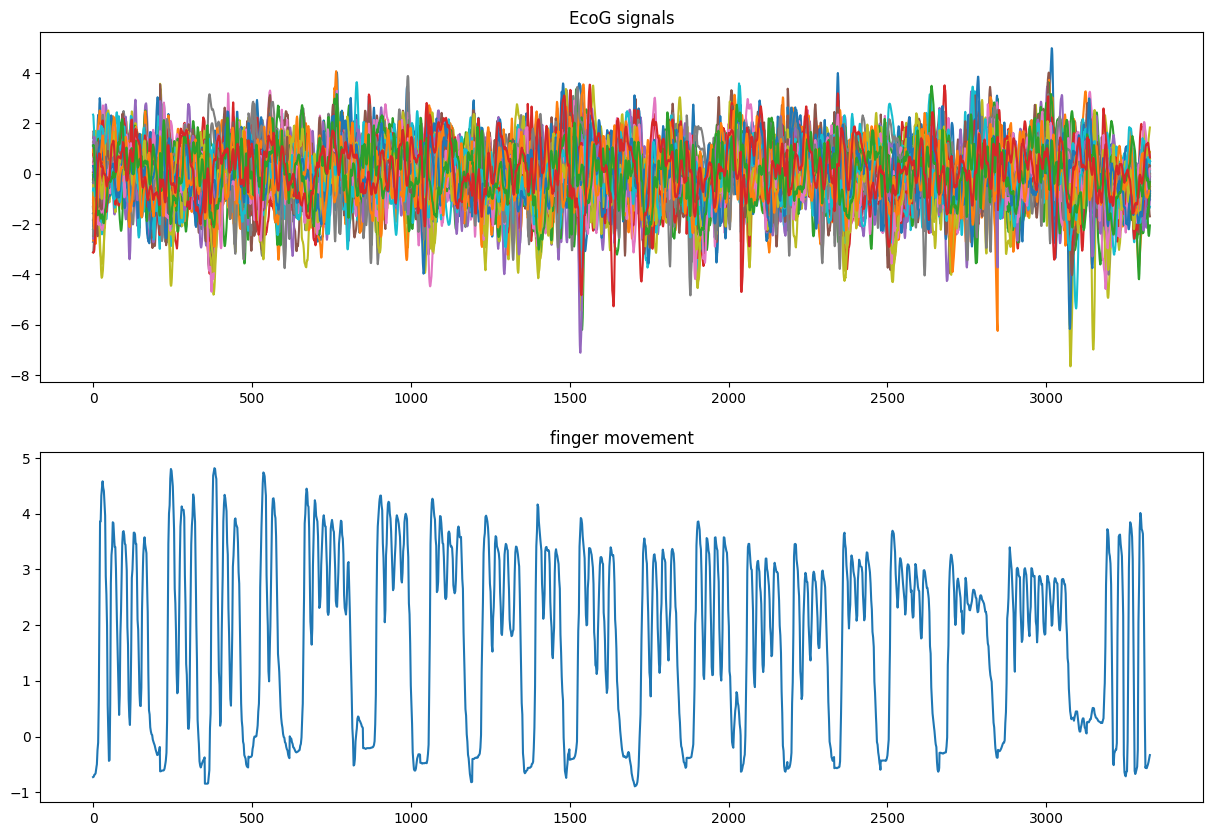

In [58]:
Xall,Yall,Fe=ECoG["Xall"],ECoG["Yall"],ECoG["Fe"]
fig,axes=plt.subplots(2,1,figsize=(15,10))
axes[0].plot(Xall)
axes[0].set_title("EcoG signals")
axes[1].plot(Yall)
axes[1].set_title("finger movement")
plt.show()

**Interpretation:**

The plot offers a visual depiction of how the EcoG signals and finger movements change throughout time. It's clear that there are discernible patterns and trends in the signals, which may have a connection with the finger movements.

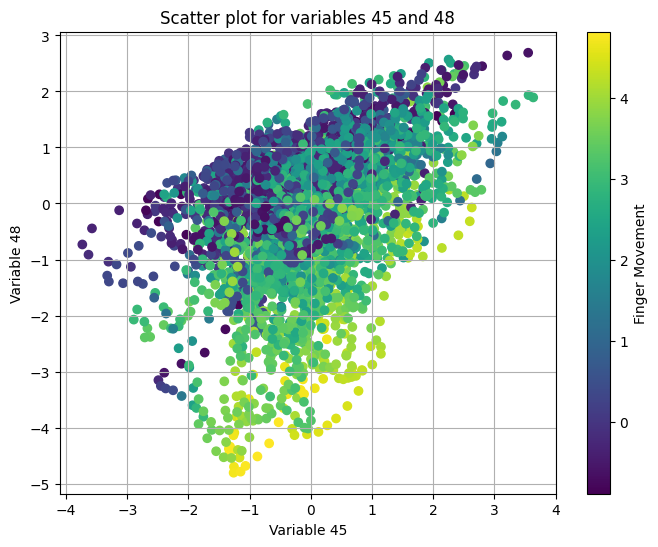

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(Xall[:, 45], Xall[:, 48], c=Yall, cmap='viridis')
plt.xlabel('Variable 45')
plt.ylabel('Variable 48')
plt.colorbar(label='Finger Movement')
plt.title('Scatter plot for variables 45 and 48')
plt.grid(True)
plt.show()

**Interpretation**:

We see a degradation of color from yellow to blue reflecting the how values of the dataset are distributed among the variables $48$ and $45$.
The visualization provides insights into the clustering and distribution of the data based on variables 45 and 48. It's evident that there are regions in the plot where samples with similar target values group together. This indicates potential correlations between these two variables and the finger movement.

In [60]:
n=1000                                                                          # train dataset length
m=len(Xall)-n                                                                   # test dataset length
x_train,x_test=Xall[:n,:],Xall[n:,:]
y_train,y_test=Yall[:n,:],Yall[n:,:]

# Least Squares regression (LS)

In [61]:
X=np.concatenate((x_train,np.ones(shape=(x_train.shape[0],1))),1)

In [62]:
theta=np.linalg.solve(X.T.dot(X),X.T.dot(y_train))
w,b=theta[:-1],theta[-1]

In [63]:
y_hat_train=x_train.dot(w)+b
y_hat_test=x_test.dot(w)+b

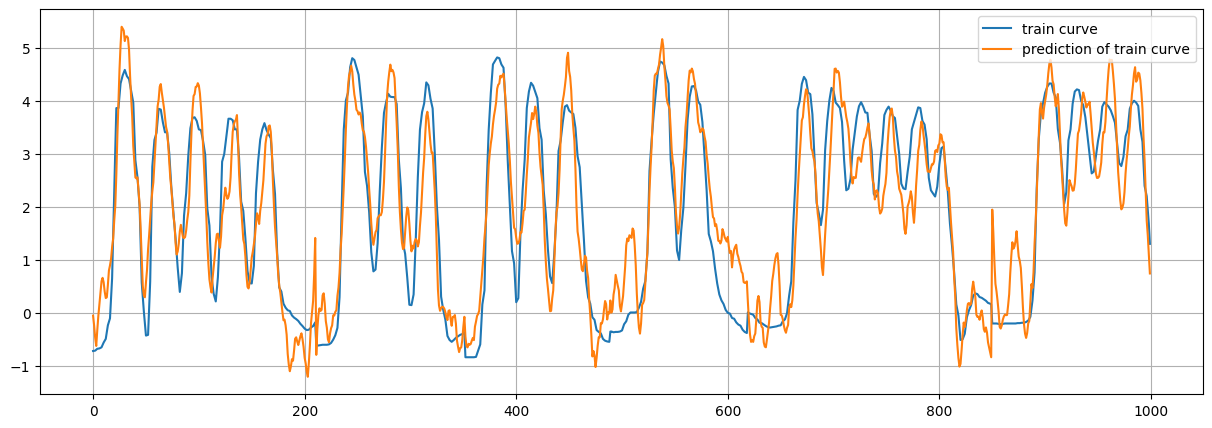

In [64]:
plt.figure(figsize=(15,5))
plt.plot(y_train,label="train curve")
plt.plot(y_hat_train,label="prediction of train curve")
plt.legend()
plt.grid(True)
plt.show()

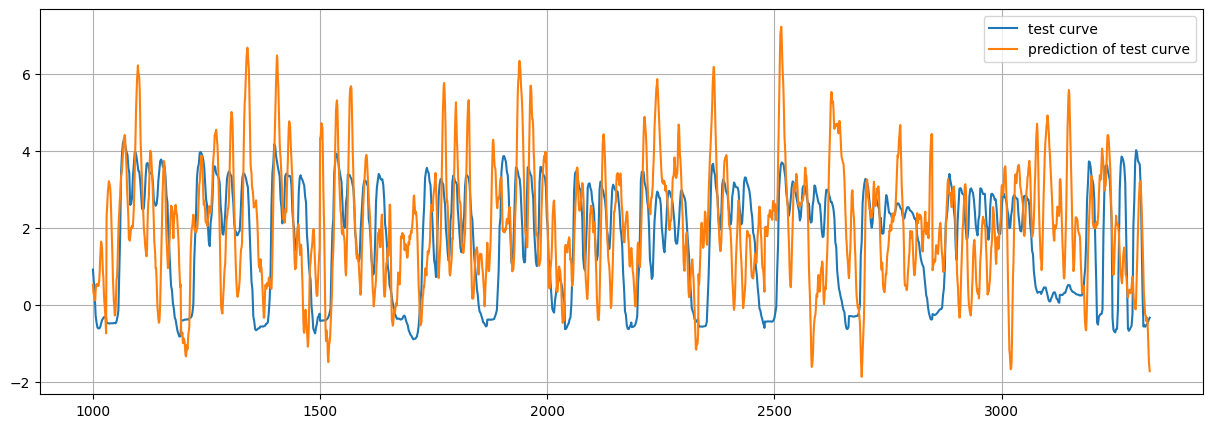

In [65]:
plt.figure(figsize=(15,5))
plt.plot(range(n,len(Yall)),y_test,label="test curve")
plt.plot(range(n,len(Yall)),y_hat_test,label="prediction of test curve")
plt.legend()
plt.grid(True)
plt.show()

On the train dataset, the prediction curve fits the train curve as expected. However, if we take a look on the performance on the test dataset, we see that at the beginnig the prediction curve approximates the test curve. But as long as we follow their correspondance along time we see that prediction curve predicts badly the test one. This reflects bad linearity relationship between the predicted values and the ground truth.

We can understand this by the fact that brain behavior (giving the order to the finger to move in which direction) is not easily predictable by electrods for a long period of time for a given measurement.

In [66]:
print(f'MSE on train: {mean_squared_error(y_train,y_hat_train)}')
print(f'MSE on test: {mean_squared_error(y_test,y_hat_test)}')

print(f'R² on train: {metrics.r2_score(y_train,y_hat_train)}')
print(f'R² on test: {metrics.r2_score(y_test,y_hat_test)}')

MSE on train: 0.5040654614476061
MSE on test: 3.0455368767601616
R² on train: 0.8395001217500111
R² on test: -0.42817006302225225


On train dataset, we have a low value of $MSE$ error of $0.5$ and a $0.83$ value of $R^2$ reflecting a good fit to the train dataset. However, on the test dataset we had a value of $3$ for the $MSE$ error and $-0.42$ for $R^2$ reflecting bad prediction on test dataset and absence of correlation between predicted values and the true value of test dataset. 

We conclude that we have a problem of **overfitting** on the train set since which is expected since we work in high dimension. A good solution mmay be to use regularization (Lasso and Ridge) and retrain the model.

In [67]:
LS=LinearRegression()
LS.fit(x_train,y_train)

LinearRegression()

In [68]:
print(sum((w.flatten()-LS.coef_.flatten())**2))                              #Squared error between weights
print(((b-LS.intercept_)**2)[0])                                             #Squared error between intercepts

2.0308168198458532e-27
4.437342591868191e-31


We note that we retrieve the same values of weights and intercept as the linear regression model we created at first.

# Ridge regression

In [69]:
Ridge_reg = Ridge(alpha=1)
Ridge_reg.fit(x_train,y_train)

Ridge(alpha=1)

In [70]:
y_train_hat=Ridge_reg.predict(x_train)
y_test_hat=Ridge_reg.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.5041768297327898
MSE on test: 3.003842959535574
R² on train: 0.8394646608871272
R² on test: -0.4086181722391633


When $\lambda$ is set to 1, the resulting mean squared error ($MSE$) and coefficient of determination ($R^2$) are roughly equivalent to those obtained from a basic linear regression. However, this choice of $\lambda$ doesn't effectively address the issue of overfitting. It's advisable to consider larger $\lambda$ values to impose more significant penalties on the model's weights.

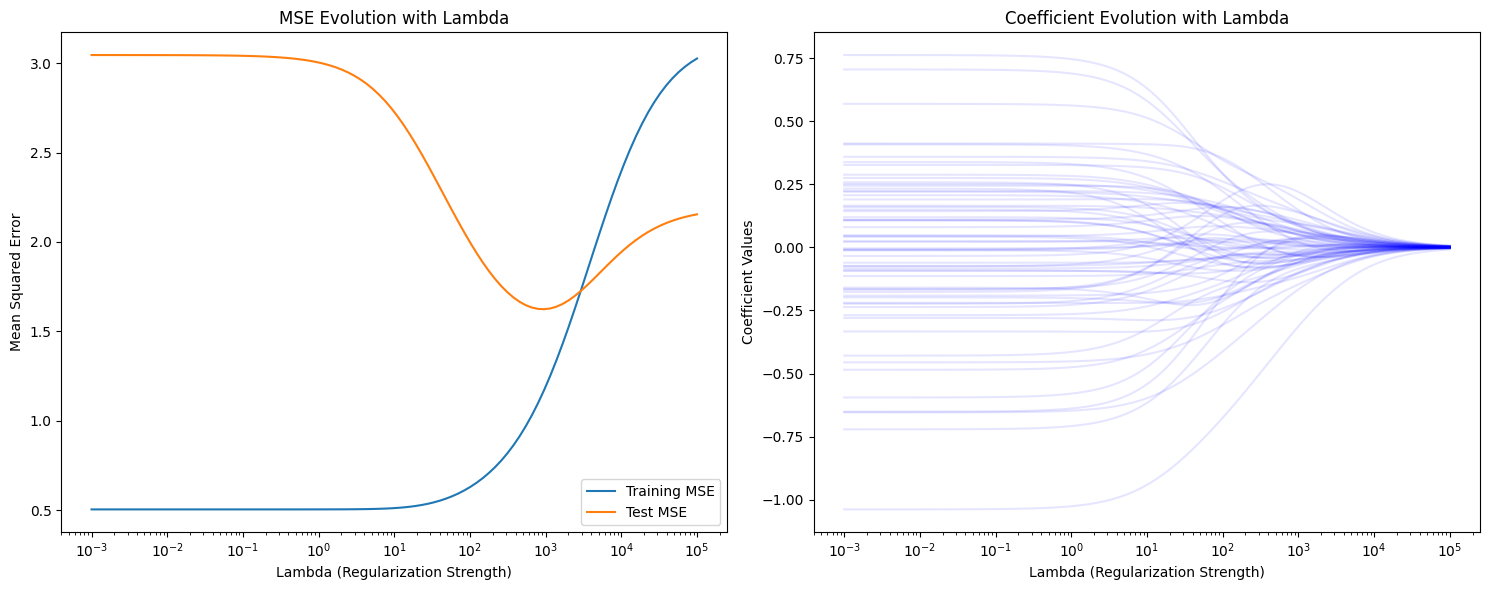

In [71]:
# Defining a range of lambda values
lambdas = np.logspace(-3, 5, 100)

# Lists to store MSE values for training and test data
mse_train_values = []
mse_test_values = []

# List to store coefficients for each lambda
coefs = []

for l in lambdas:
    ridge = Ridge(alpha=l)
    ridge.fit(x_train, y_train)
    
    # Predicting and computing MSE
    Y_train_pred_lambda = ridge.predict(x_train)
    Y_test_pred_lambda = ridge.predict(x_test)
    mse_train_values.append(mean_squared_error(y_train, Y_train_pred_lambda))
    mse_test_values.append(mean_squared_error(y_test, Y_test_pred_lambda))
    
    # Storing coefficients
    coefs.append(ridge.coef_)

# Plotting the evolution of MSE with lambda
plt.figure(figsize=(15, 6))

# MSE Evolution with Lambda
plt.subplot(1, 2, 1)
plt.plot(lambdas, mse_train_values, label='Training MSE')
plt.plot(lambdas, mse_test_values, label='Test MSE')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('MSE Evolution with Lambda')

# Coefficient Evolution with Lambda
plt.subplot(1, 2, 2)
coefs = np.array(coefs)
for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], color='b', alpha=0.1)
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Values')
plt.title('Coefficient Evolution with Lambda')

plt.tight_layout()
plt.show()

In [72]:
index=np.argmin(mse_test_values)
lmbd_opt=lambdas[index]
print("valeur optimale de lambda: {}".format(lmbd_opt)) 
print("MSE error on Test: {}".format(mse_test_values[np.argmin(mse_test_values)])) 
Ridge_opt=Ridge(alpha=lmbd_opt)
Ridge_opt.fit(x_train,y_train)

valeur optimale de lambda: 954.5484566618347
MSE error on Test: 1.6239059826952074


Ridge(alpha=954.5484566618347)

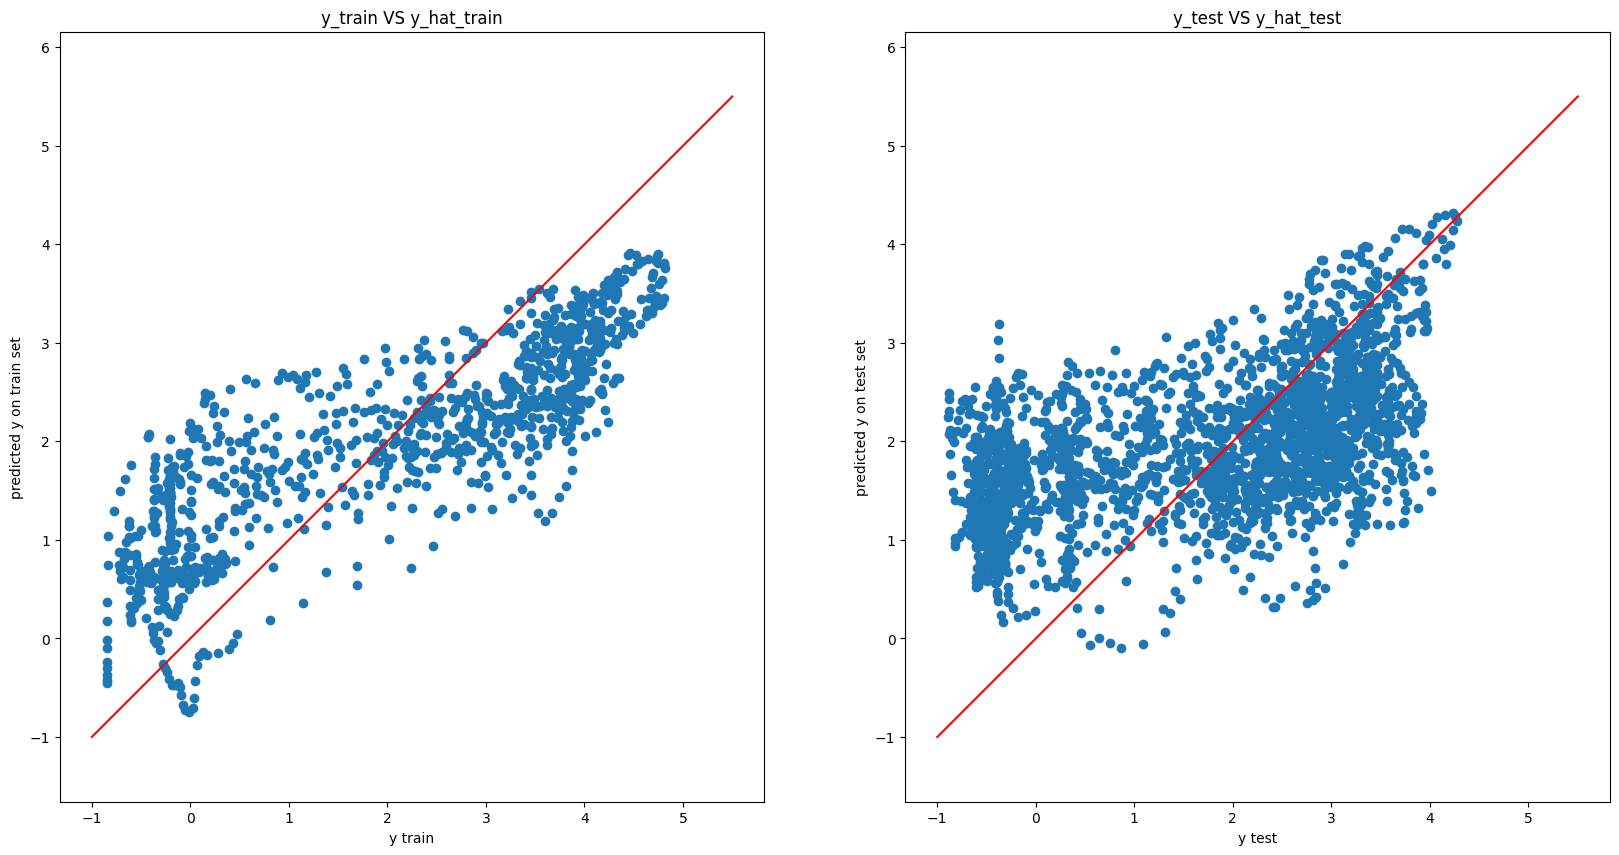

In [73]:
y_hat_test=Ridge_opt.predict(x_test)
y_hat_train=Ridge_opt.predict(x_train)

fig,axes=pl.subplots(1,2,figsize=(20,10))
line = mlines.Line2D([-1, 5.5], [-1, 5.5], color='red',axes=axes[0])

axes[0].scatter(y_train,y_hat_train)
axes[0].add_line(line)
axes[0].set_xlabel("y train")
axes[0].set_ylabel("predicted y on train set")
axes[0].set_title("y_train VS y_hat_train")
axes[0].axis('equal')

line = mlines.Line2D([-1, 5.5], [-1, 5.5], color='red',axes=axes[1])

#axes[1].add_line(line)
axes[1].scatter(y_test,y_hat_test)
axes[1].add_line(line)
axes[1].set_xlabel("y test")
axes[1].set_ylabel("predicted y on test set")
axes[1].set_title("y_test VS y_hat_test")
axes[1].axis('equal')

pl.show()

**Observation**:

We observe that there isn't a strong alignment between the predictions and the actual values in both the training and test datasets, even though the spread is narrower in the training dataset. Consequently, the ridge regressor did not significantly improve the performance of the least squares (LS) regressor.

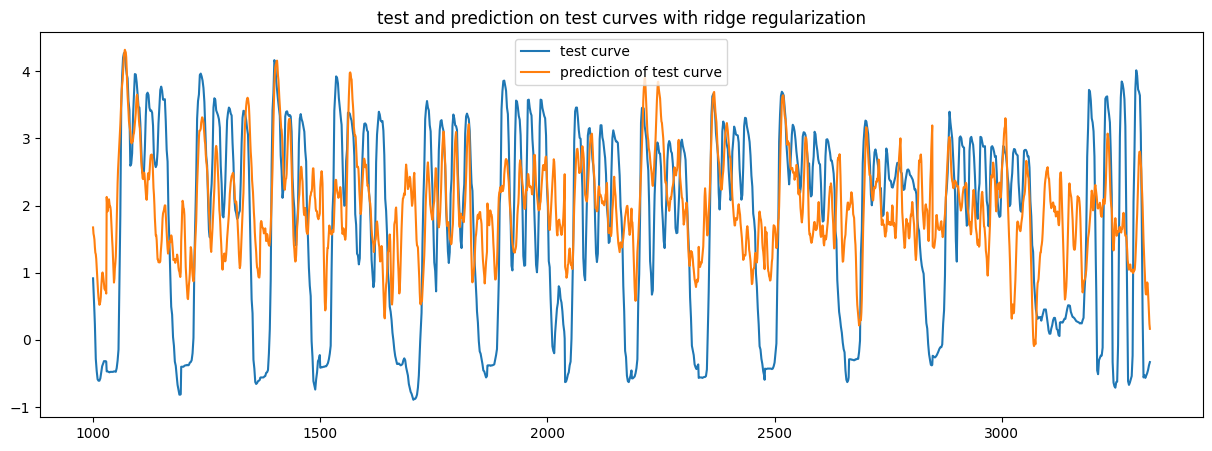

In [74]:
plt.figure(figsize=(15,5))
plt.plot(range(n,n+m),y_test,label="test curve")
plt.plot(range(n,n+m),y_hat_test,label="prediction of test curve")
plt.title("test and prediction on test curves with ridge regularization")
plt.legend()
plt.show()

**Observation**:

On the test dataset, we see that the predicted curve captures the variations of the test curve. However, it doesn't reach the low values of the test curve and at the end we see that the prediction is not accurate. But in general the obtained curve is better than the one of LS. In fact we don't get no more the very large values that we saw in the prediction curve over test dataset with the LS model.

In [75]:
print(f'MSE on train: {mean_squared_error(y_train,y_hat_train)}')
print(f'MSE on test: {mean_squared_error(y_test,y_hat_test)}')

print(f'R² on train: {metrics.r2_score(y_train,y_hat_train)}')
print(f'R² on test: {metrics.r2_score(y_test,y_hat_test)}')

MSE on train: 1.1719430382009632
MSE on test: 1.6239059826952074
R² on train: 0.6268406996047915
R² on test: 0.23848766129037868


For the train dataset, we note that the MSE value for ridge regressor is $3$ times higher than MSE value on the LS regressor. And the $R^2$ value decreased is lower by a value of $0.2$ compared to the $R^2$ of LS regressor.

For test dataset, the MSE error is lower for ridge regressor (approximately the half). And the $R^2$ value of the ridge regressor is higher than the $R^2$ of the LS model.

We can understand by this, that with the ridge regularizer, we could alleviate the overfitting problem. Performance on the train set became much lower than in the LS model but we gained better performance on test set.

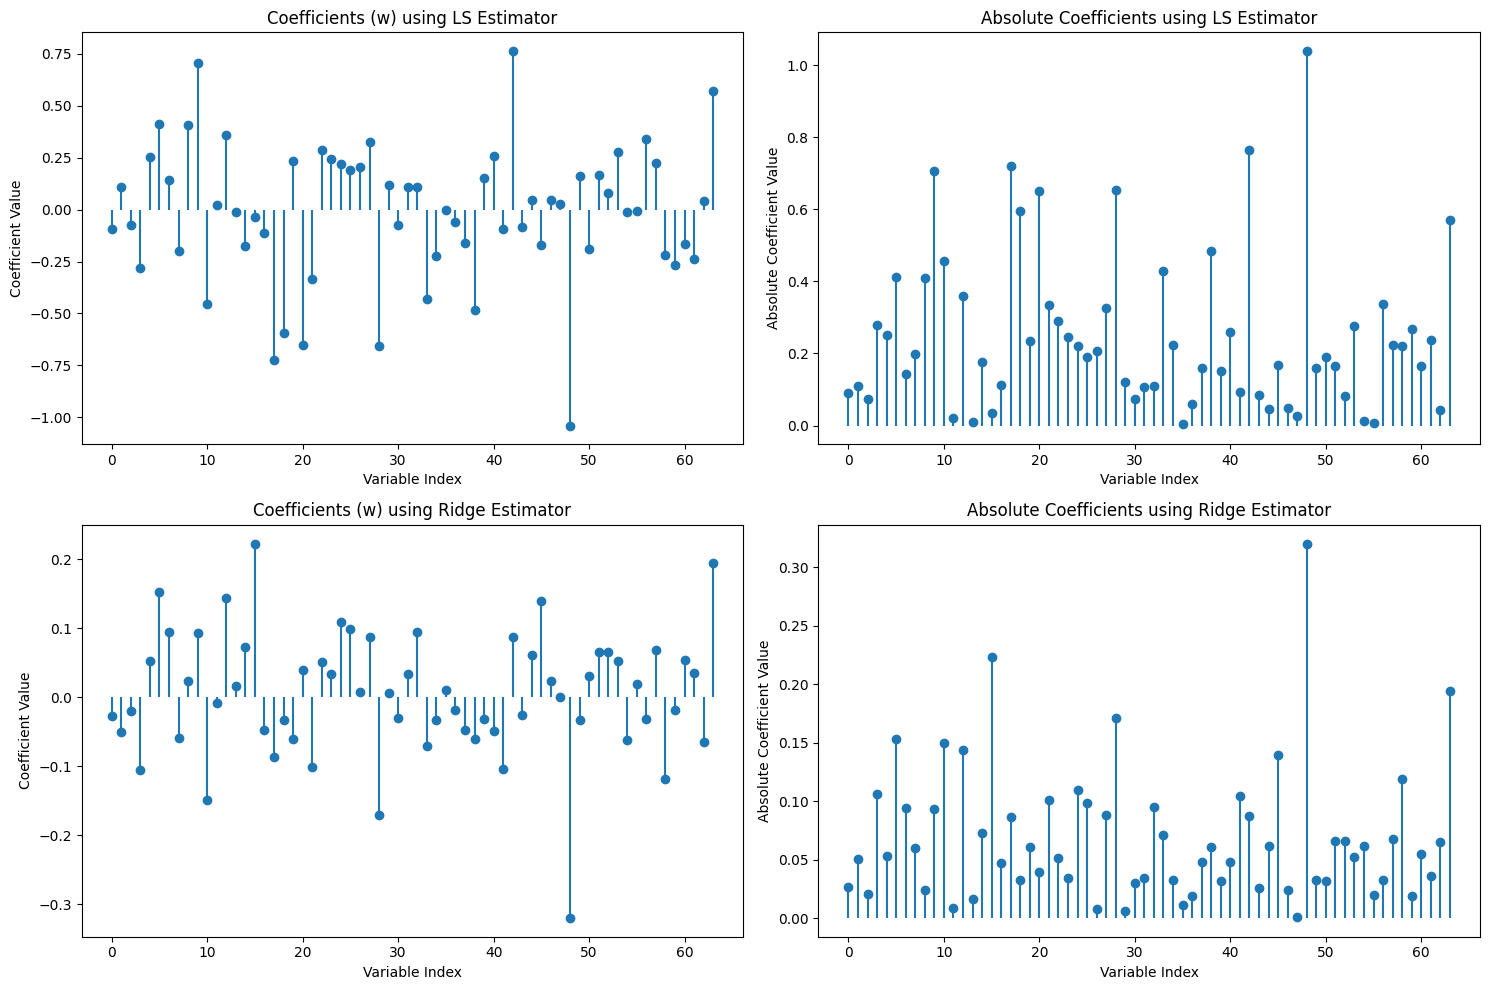

In [76]:
# Plotting the coefficients w for both LS and Ridge estimator
plt.figure(figsize=(15, 10))

# Coefficients for LS estimator
plt.subplot(2, 2, 1)
plt.stem(w, basefmt=" ")
plt.title('Coefficients (w) using LS Estimator')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')

# Absolute coefficients for LS estimator
plt.subplot(2, 2, 2)
plt.stem(np.abs(w), basefmt=" ")
plt.title('Absolute Coefficients using LS Estimator')
plt.xlabel('Variable Index')
plt.ylabel('Absolute Coefficient Value')

# Coefficients for Ridge estimator
plt.subplot(2, 2, 3)
plt.stem(Ridge_opt.coef_[0], basefmt=" ")
plt.title('Coefficients (w) using Ridge Estimator')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')

# Absolute coefficients for Ridge estimator
plt.subplot(2, 2, 4)
plt.stem(np.abs(Ridge_opt.coef_[0]), basefmt=" ")
plt.title('Absolute Coefficients using Ridge Estimator')
plt.xlabel('Variable Index')
plt.ylabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()

If we compare the plotted values of weights for both models (LS and ridge regressors), we can see that for the LS regressor many variables have important values of weights. However by doing a ridge regularization, many variables had their weights shrunk closely to zero (with no equality to zero for most cases this is particular to ridge). For other weights, they have been reduced and they are the most important in prediction like $w_{16},w_{29},w_{49}$ and $w_{64}$. 

# Variable selection with the Lasso

In [77]:
Lasso_reg = Lasso()
Lasso_reg.fit(x_train,y_train)

Lasso()

In [78]:
y_train_hat=Lasso_reg.predict(x_train)
y_test_hat=Lasso_reg.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 3.1405971577280063
MSE on test: 2.190675841640482
R² on train: 0.0
R² on test: -0.02729265197579034


When we use a Lasso regularized model with the default parameter value ($\lambda=1$), we notice that it makes more mistakes on the training dataset but fewer mistakes on the test dataset compared to the original least squares (LS) model. Even though we haven't fine-tuned the parameter, using the default value of $\lambda=1" in the Lasso model appears to help mitigate overfitting. As for correlation values, both the training and test sets show zero correlations, indicating that the fitted model doesn't capture any linear relationships between the input data and its predictions.

In [79]:
# Defining a range of alpha values (regularization strength)
lambd = np.logspace(-3, 5, 100)

# Lists to store MSE values for training and test data
mse_train_lasso = []
mse_test_lasso = []

# List to store coefficients for each alpha
coefs_lasso = []

for lamb in lambd:
    lasso = Lasso(alpha=lamb)
    lasso.fit(x_train, y_train)
    
    # Predicting and computing MSE
    Y_train_pred_lasso = lasso.predict(x_train)
    Y_test_pred_lasso = lasso.predict(x_test)
    mse_train_lasso.append(mean_squared_error(y_train, Y_train_pred_lasso))
    mse_test_lasso.append(mean_squared_error(y_test, Y_test_pred_lasso))
    
    # Storing coefficients
    coefs_lasso.append(lasso.coef_)

print("Lasso regression for varying alpha values completed.")

Lasso regression for varying alpha values completed.


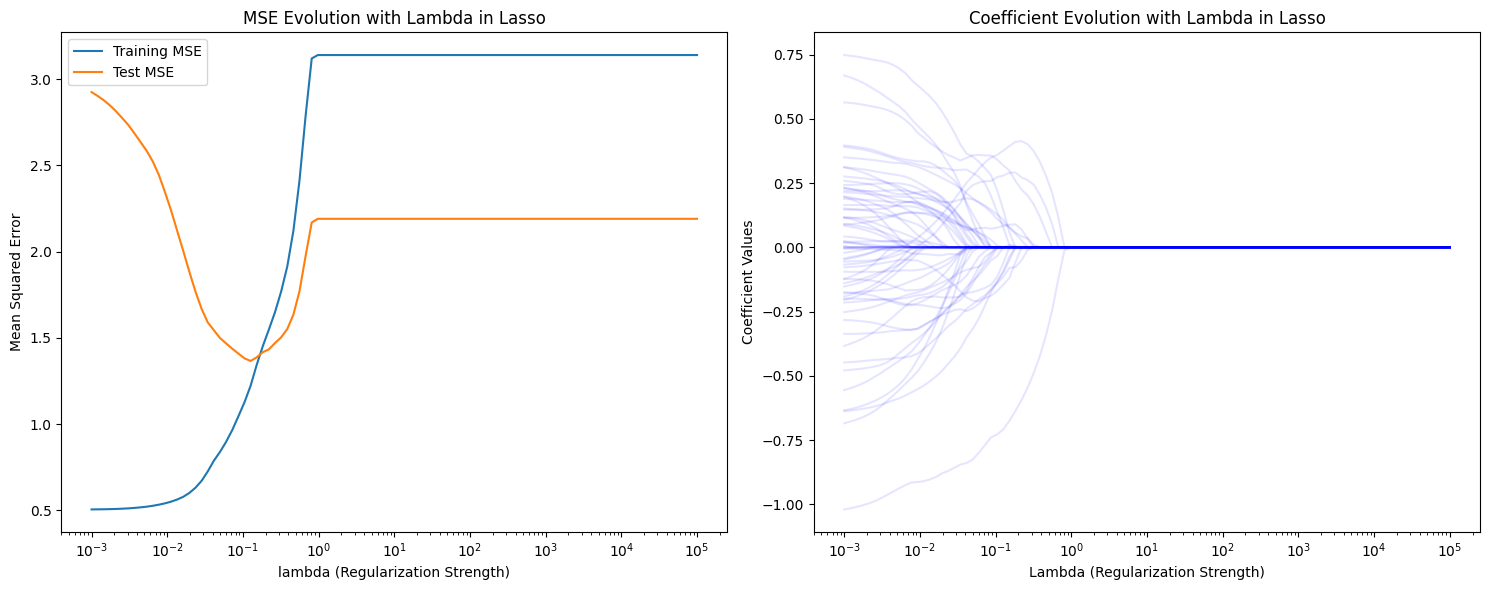

In [80]:
plt.figure(figsize=(15, 6))

# MSE Evolution with Lambda
plt.subplot(1, 2, 1)
plt.plot(lambd, mse_train_lasso, label='Training MSE')
plt.plot(lambd, mse_test_lasso, label='Test MSE')
plt.xscale('log')
plt.xlabel('lambda (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('MSE Evolution with Lambda in Lasso')

# Coefficient Evolution with Lambda
plt.subplot(1, 2, 2)
coefs_lasso = np.array(coefs_lasso)
for i in range(coefs_lasso.shape[1]):
    plt.plot(lambd, coefs_lasso[:, i], color='b', alpha=0.1)
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Values')
plt.title('Coefficient Evolution with Lambda in Lasso')

plt.tight_layout()
plt.show()


**Observations:**

- As the regularization strength ($( \lambda $)) increases, the MSE for the test data first decreases, reaching an optimal value, and then starts to increase. This suggests that there's an optimal ($( \lambda $)) value that minimizes the test MSE.
- The coefficients of the features tend to shrink towards zero as ($( \lambda $)) increases due to L1 regularization in Lasso. For very high values of ( $\lambda $ ), many coefficients become exactly zero, showcasing the feature selection capability of Lasso.
- The "blue cloud" in the coefficient evolution plot shows the shrinking behavior of Lasso regression. As ($( \lambda $)) grows, more and more coefficients are pushed to zero.


In [81]:
# Identifying the best lambda
best_lambd = lambd[np.argmin(mse_test_lasso)]

# Retraining the Lasso model with the best lambda
Lasso_opt = Lasso(alpha=best_lambd)
Lasso_opt.fit(x_train, y_train)

print(f"Best alpha for Lasso regression: {best_lambd:.5f}")


Best alpha for Lasso regression: 0.12619


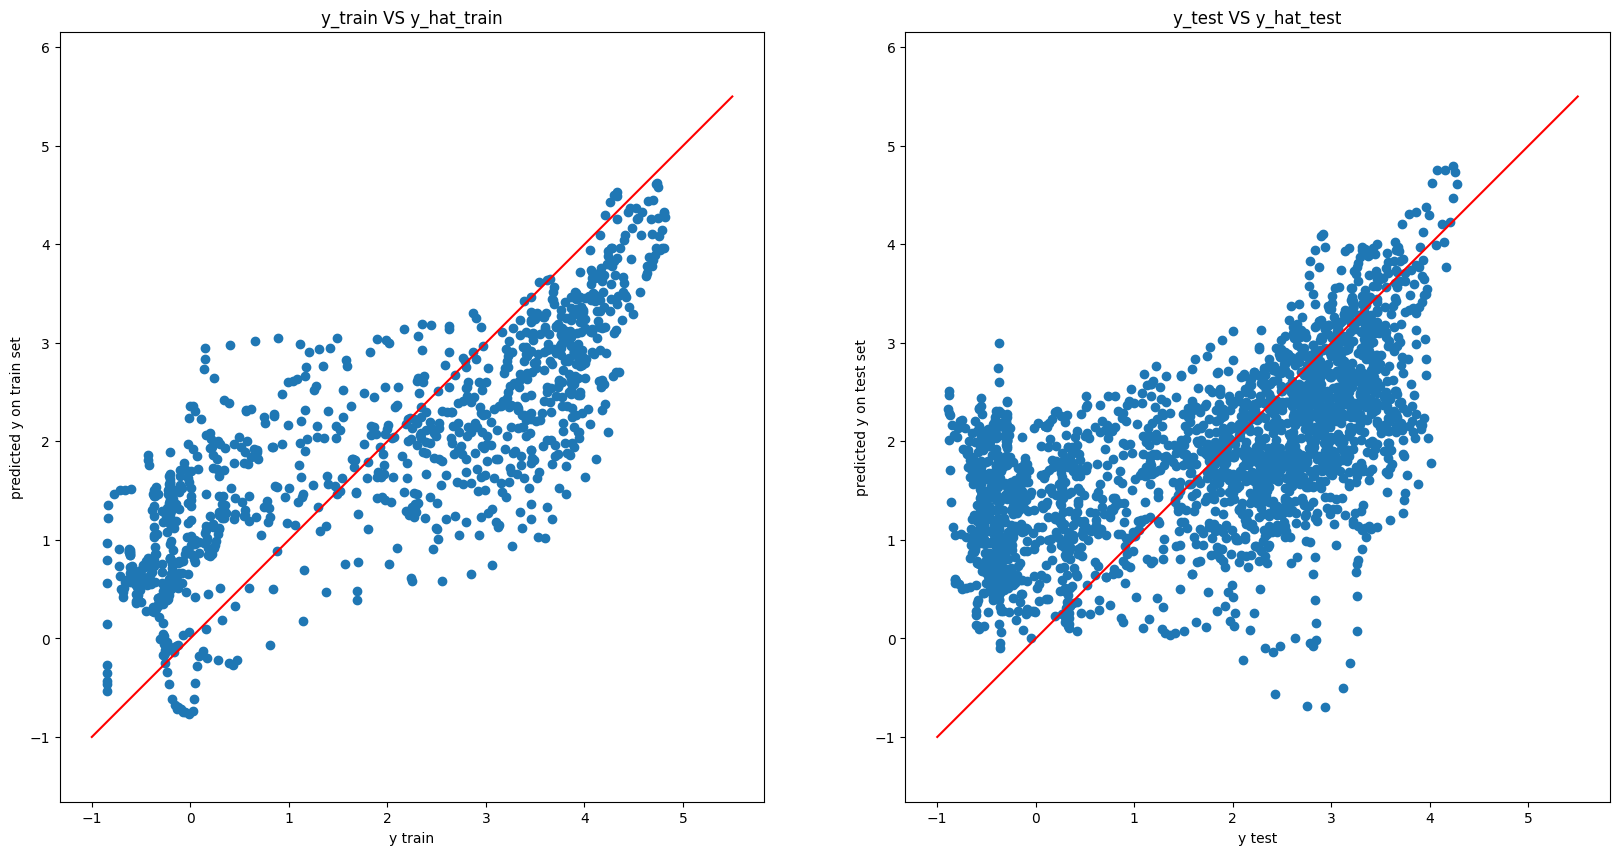

In [82]:
y_hat_test=Lasso_opt.predict(x_test)
y_hat_train=Lasso_opt.predict(x_train)

fig,axes=pl.subplots(1,2,figsize=(20,10))
line = mlines.Line2D([-1, 5.5], [-1, 5.5], color='red',axes=axes[0])

axes[0].scatter(y_train,y_hat_train)
axes[0].add_line(line)
axes[0].set_xlabel("y train")
axes[0].set_ylabel("predicted y on train set")
axes[0].set_title("y_train VS y_hat_train")
axes[0].axis('equal')

line = mlines.Line2D([-1, 5.5], [-1, 5.5], color='red',axes=axes[1])

#axes[1].add_line(line)
axes[1].scatter(y_test,y_hat_test)
axes[1].add_line(line)
axes[1].set_xlabel("y test")
axes[1].set_ylabel("predicted y on test set")
axes[1].set_title("y_test VS y_hat_test")
axes[1].axis('equal')

pl.show()

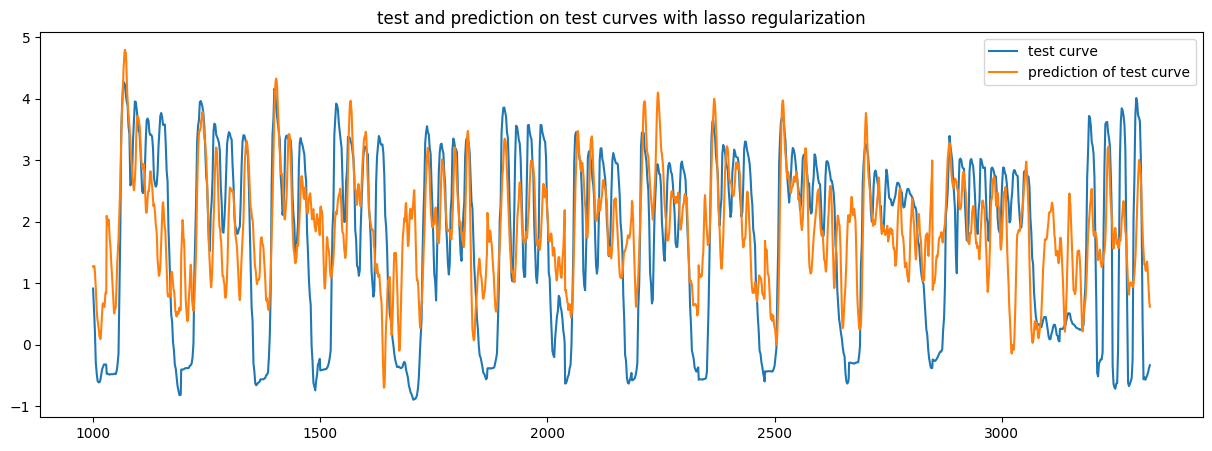

In [83]:
y_hat_test=Lasso_opt.predict(x_test)
y_hat_train=Lasso_opt.predict(x_train)

pl.figure(figsize=(15,5))
pl.plot(range(n,n+m),y_test,label="test curve")
pl.plot(range(n,n+m),y_hat_test,label="prediction of test curve")
pl.title("test and prediction on test curves with lasso regularization")
pl.legend()
pl.show()

**Observation**

With the lassor regularizer, we see that we had a very good approximation of the test curve. The predicted curve simulates well the test curve by reaching low values and following its variation. We see also that at the end the prediction is better than in the previous cases.

In [84]:
# Computing performance metrics for best Lasso model
mse_train_best_lasso = mean_squared_error(y_train, y_hat_train)
mse_test_best_lasso = mean_squared_error(y_test, y_hat_test)
r2_train_best_lasso = metrics.r2_score(y_train, y_hat_train)
r2_test_best_lasso = metrics.r2_score(y_test, y_hat_test)

print(f"Best Lasso Regression Performance Metrics:")
print(f"Train MSE: {mse_train_best_lasso:.4f}")
print(f"Test MSE: {mse_test_best_lasso:.4f}")
print(f"Train R^2: {r2_train_best_lasso:.4f}")
print(f"Test R^2: {r2_test_best_lasso:.4f}")

Best Lasso Regression Performance Metrics:
Train MSE: 1.2216
Test MSE: 1.3660
Train R^2: 0.6110
Test R^2: 0.3595


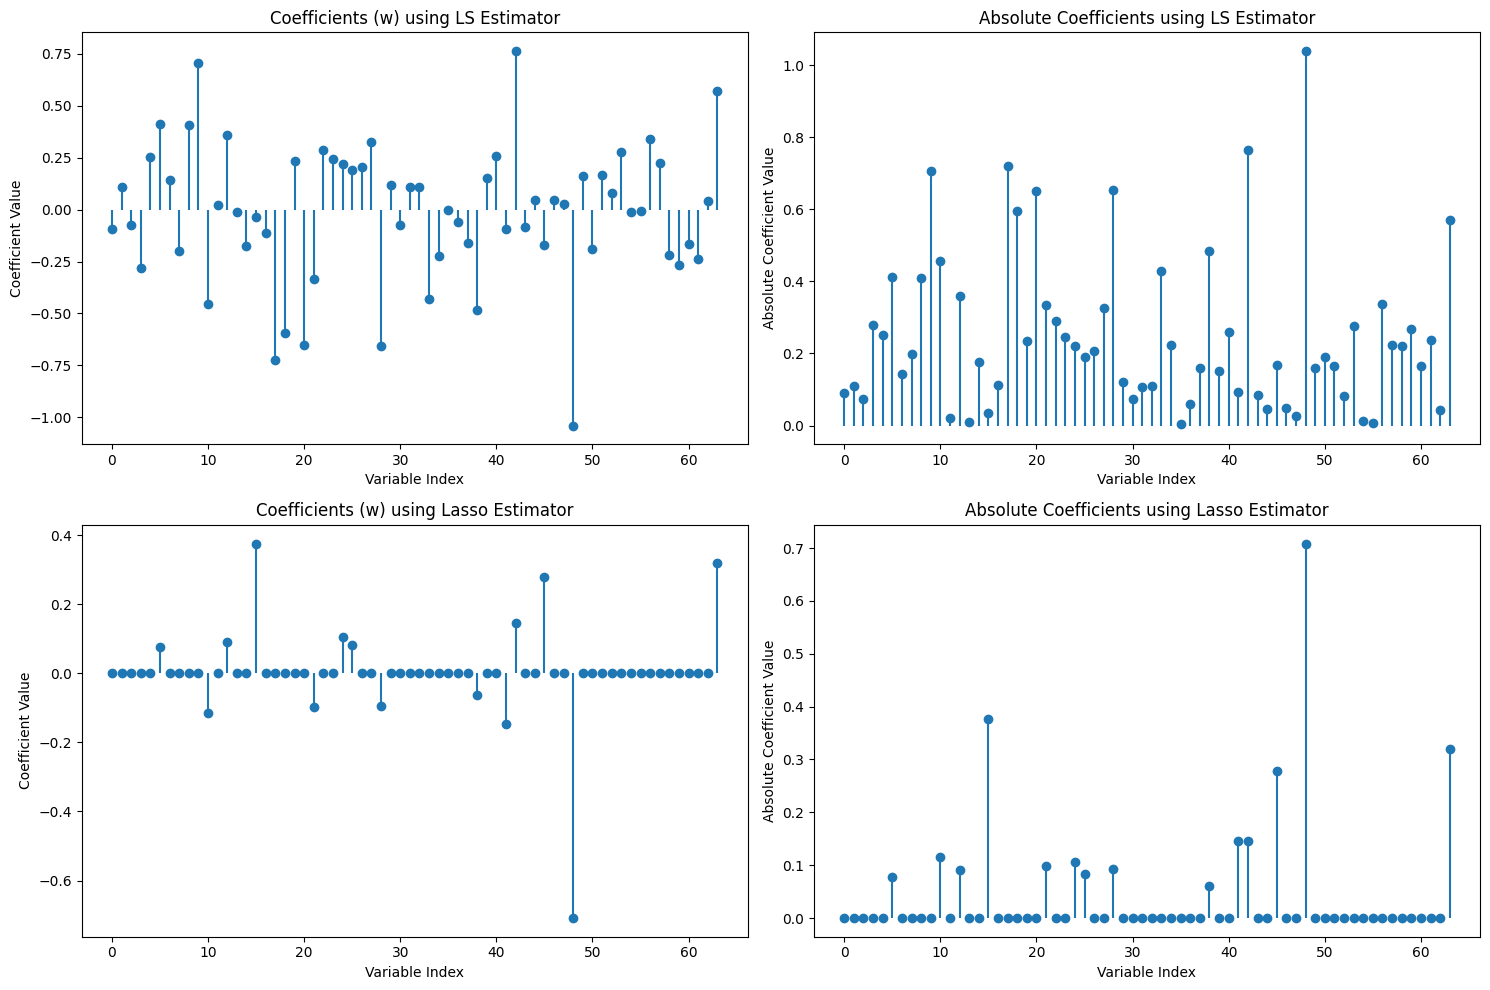

In [85]:
# Plotting the coefficients w for both LS and Ridge estimator
plt.figure(figsize=(15, 10))

# Coefficients for LS estimator
plt.subplot(2, 2, 1)
plt.stem(w, basefmt=" ")
plt.title('Coefficients (w) using LS Estimator')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')

# Absolute coefficients for LS estimator
plt.subplot(2, 2, 2)
plt.stem(np.abs(w), basefmt=" ")
plt.title('Absolute Coefficients using LS Estimator')
plt.xlabel('Variable Index')
plt.ylabel('Absolute Coefficient Value')

# Coefficients for Ridge estimator
plt.subplot(2, 2, 3)
plt.stem(Lasso_opt.coef_, basefmt=" ")
plt.title('Coefficients (w) using Lasso Estimator')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')

# Absolute coefficients for Ridge estimator
plt.subplot(2, 2, 4)
plt.stem(np.abs(Lasso_opt.coef_), basefmt=" ")
plt.title('Absolute Coefficients using Lasso Estimator')
plt.xlabel('Variable Index')
plt.ylabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()

In [86]:
print("number of non null weights: {}".format(sum(Lasso_opt.coef_!=0)))

number of non null weights: 14


**Observation**

We see that the lasso regularizer shuts down some variables by reducing their weights to zero. That's why we speak about variable selection with Lasso. By inspecting the weights of variables in the above plot, we see that variables with significantly non zero weights are $w_{16},w_{46},w_{49}$ and $w_{64}$. The other variables had their weights shrunk to zero or got very close to zero.
The Lasso method selects features based on the number of variables with non-zero weights, and in this case, we have 14 variables with non-null coefficients.

The reduced number of electrodes doesn't play a crucial role in the prediction task. This can be explained by the fact that finger movement is associated with a specific region in the brain. Only the electrodes placed in that region are responsible for accurate predictions, while the others are unnecessary. In this task, we find that a small number of electrodes yield precise results. Therefore, using a limited number of electrodes for measurements is more effective than surrounding the subject's brain with numerous electrodes.

# Nonlinear regression

## Random forest

In [87]:
rf=RandomForestRegressor(random_state=seed)
rf.fit(x_train,y_train)
y_train_hat=rf.predict(x_train)
y_test_hat=rf.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.02232492543528405
MSE on test: 1.6256841820937247
R² on train: 0.9928915030123014
R² on test: 0.23765379479990023


**Observation**

The basic random forest model tends to memorize the training data too closely, which is an issue called overfitting. When we test it on new data, it performs better than the simple LS model, but it doesn't outperform the lasso and ridge models.

In [88]:
R=0
MSE=2
ngrid=30
param=0
param_grid={"max_features":np.linspace(0.5,0.7,num=ngrid)}                      
for i in range(ngrid):
    model=RandomForestRegressor(max_features=param_grid["max_features"][i],random_state=seed)                                   
    model.fit(x_train,y_train)
    y_hat=model.predict(x_test)
    mse=mean_squared_error(y_test,y_hat)
    r_2=metrics.r2_score(y_test,y_hat)
    if (abs(r_2)>R) and (mse<MSE):
        R=r_2
        MSE=mse
        param=param_grid["max_features"][i]

In [89]:
rf_opt=RandomForestRegressor(max_features=param)
rf_opt.fit(x_train,y_train)
print("optimal value of max_features: {}".format(param))

optimal value of max_features: 0.5689655172413793


In [90]:
y_train_hat=rf_opt.predict(x_train)
y_test_hat=rf_opt.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.022634382731891698
MSE on test: 1.574277102651802
R² on train: 0.9927929684721915
R² on test: 0.2617605631160542


**Observation**

We could reduce the MSE error by a value of $0.08$ and enhance the $R^2$ value by $0.05$ by tuning the max_features parameter, which shows that the model performance is dependent on the choice of its parameters.
After conducting a grid search on the number of features used to split data in decision tree nodes, we found that the best result was achieved with a 56% selection of variables.

This improved performance is evident in the test data, where the Mean Squared Error (MSE) decreased from 1.63 to 1.57 for the model with default settings, and the R-squared ($R^2$) value increased from 0.24 to 0.261. However, the performance on the training data remained relatively consistent, indicating a potential overfitting issue.

Comparing the random forest model to the least squares (LS) model, the random forest model outperforms the LS model with a higher $R^2$ value and lower MSE.

Compared to the Ridge regressor, the random forest model exhibits better performance on the test dataset, with lower MSE and a higher $R^2$. This improvement is because the random forest model selects fewer variables for splits, while the Ridge model only reduces the weights of some variables.

However, when comparing the random forest model to the Lasso regressor, the Lasso model performs better. It achieves a lower MSE (1.36) on the test dataset compared to the random forest model's MSE of 1.6. In this case, Lasso's variable selection proves to be more effective than the random forest model.

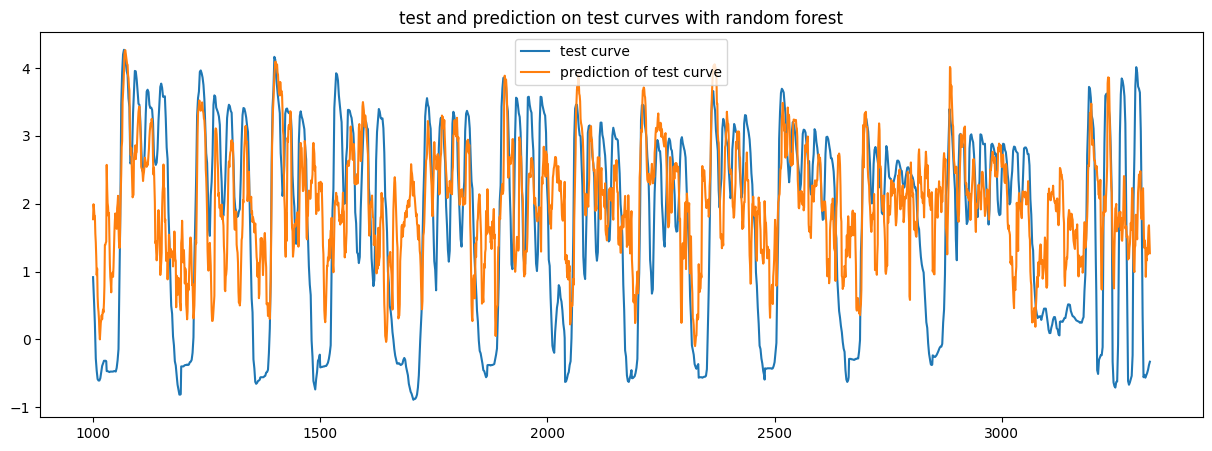

In [91]:
plt.figure(figsize=(15,5))
plt.plot(range(n,n+m),y_test,label="test curve")
plt.plot(range(n,n+m),y_test_hat,label="prediction of test curve")
plt.title("test and prediction on test curves with random forest")
plt.legend()
plt.show()

**Observation**

As previously mentioned, the predictions on the test dataset are reasonably accurate. They outperform the least squares (LS) and ridge models but fall slightly short of the performance achieved by the lasso model. Generally, the predictions closely align with the test curve. However, towards the end, there is a noticeable disparity between the predictions and the actual data.

This discrepancy arises from the random forest regressor's tendency to assign the average value of the split zones as the prediction. Unfortunately, this average prediction value doesn't always work well for every test dataset, as is the case in our scenario.

## SVR

In [92]:
svr=SVR()
svr.fit(x_train,y_train)

y_train_hat=svr.predict(x_train)
y_test_hat=svr.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.024085982516610364
MSE on test: 1.515182870123942
R² on train: 0.9923307634481734
R² on test: 0.28947213490412815


**Observation**

The default Support Vector Regression (SVR) model exhibits a tendency to overfit the training dataset, indicated by its very low Mean Squared Error (MSE) and an R-squared ($R^2$) value of approximately 1 on the training set.

In contrast, when we evaluate the SVR model on the test dataset, it outperforms the least squares (LS) and ridge models but falls short of surpassing the lasso model in terms of performance.

In [93]:
R=0
MSE=2
ngrid=30
param={"epsilon":0,"C":0}
param_grid={"epsilon":np.logspace(-4,-1,ngrid),"C":np.linspace(0.1,10,ngrid)} 
for c in param_grid["C"]:
    for eps in param_grid["epsilon"]:
        model=SVR(epsilon=eps,C=c)                                   
        model.fit(x_train,y_train)
        y_hat=model.predict(x_test)
        mse=mean_squared_error(y_test,y_hat)
        r_2=metrics.r2_score(y_test,y_hat)
    if (abs(r_2)>R) and (mse<MSE):
        R=r_2
        MSE=mse
        param["epsilon"]=eps
        param["C"]=c

In [94]:
svr_opt=SVR(epsilon=param["epsilon"],C=param["C"])   
svr_opt.fit(x_train,y_train)
print("optimal value of C: {}".format(param["C"]))
print("optimal value of epsilon: {}".format(param["epsilon"]))

optimal value of C: 0.7827586206896552
optimal value of epsilon: 0.1


In [95]:
y_train_hat=svr_opt.predict(x_train)
y_test_hat=svr_opt.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.03508191572264133
MSE on test: 1.512864107005957
R² on train: 0.9888295397465046
R² on test: 0.29055949263524494


**Observation**

Our attempts to adjust the parameters of the Support Vector Regression (SVR) model did not result in significant changes to its performance on the test dataset. It appears that the SVM model's performance on our test data isn't heavily influenced by the specific model parameters.

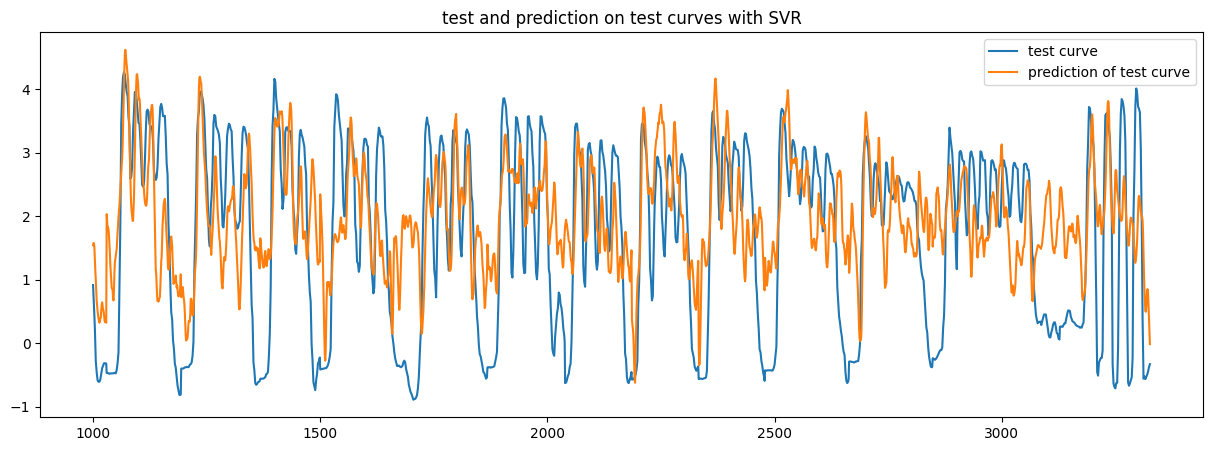

In [96]:
plt.figure(figsize=(15,5))
plt.plot(range(n,n+m),y_test,label="test curve")
plt.plot(range(n,n+m),y_test_hat,label="prediction of test curve")
plt.title("test and prediction on test curves with SVR")
plt.legend()
plt.show()

**Observation**

The SVR model provides fairly accurate predictions on the test dataset. The predicted curve closely resembles the test curve, achieving low values at certain points. However, towards the end, the predictions become less reliable.

## MLP

### MLP Classifier

In [97]:
# To use MLPClassifier for a regression task, we'll discretize the target values
# We'll achieve this by converting the continuous values into discrete classes
bins = np.linspace(Yall.min(), Yall.max(), 100)
Y_train_class = np.digitize(y_train, bins)
Y_test_class = np.digitize(y_test, bins)
# Initialize and fit the MLPClassifier with default parameters
mlp_classifier = MLPClassifier(random_state=42, max_iter=1000)
mlp_classifier.fit(x_train, Y_train_class.ravel())

# Predict on the training and test data
Y_train_mlp_classifier_pred = mlp_classifier.predict(x_train)
Y_test_mlp_classifier_pred = mlp_classifier.predict(x_test)

# Convert the predicted classes back to continuous values
Y_train_mlp_classifier_values = bins[Y_train_mlp_classifier_pred - 1]
Y_test_mlp_classifier_values = bins[Y_test_mlp_classifier_pred - 1]

# Compute MSE for the predictions
mse_train_mlp_classifier = mean_squared_error(y_train, Y_train_mlp_classifier_values)
mse_test_mlp_classifier = mean_squared_error(y_test, Y_test_mlp_classifier_values)

mse_train_mlp_classifier, mse_test_mlp_classifier

(0.0011520446587558926, 3.3622836291555895)


**Interpretation:**

The MLPClassifier, when used for this regression-like task, exhibits a very low MSE on the training data. This suggests that the model effectively captures patterns in the training data. However, the MSE on the test data is higher compared to some of the other models we've assessed, indicating potential overfitting or less than ideal generalization for this specific task.

In [98]:

# Define a parameter grid with multiple parameter combinations
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [1000, 2000]
}

# GridSearchCV with the extended parameter grid and parallel computing (n_jobs=-1)
grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(x_train, Y_train_class.ravel())

# Get the best parameters from the grid search
best_params = grid_search.best_params_
best_params

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/mahdi/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mahdi/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mahdi/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mahdi/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mahdi

{'activation': 'relu',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.01,
 'max_iter': 1000}

In [99]:
# Use the best parameters to fit the model
best_mlp_classifier = MLPClassifier(**best_params)
best_mlp_classifier.fit(x_train, Y_train_class.ravel())

# Predict on the test data
Y_test_best_mlp_classifier_pred = best_mlp_classifier.predict(x_test)

# Convert the predicted classes back to continuous values
Y_test_best_mlp_classifier_values = bins[Y_test_best_mlp_classifier_pred - 1]

# Compute Metrics for the test predictions

print(f'MSE on test: {mean_squared_error(y_test, Y_test_best_mlp_classifier_values)}')
print(f'R² on test: {metrics.r2_score(y_test, Y_test_best_mlp_classifier_values)}')

MSE on test: 3.6282690551317764
R² on test: -0.7014357253955215


By fine-tuning the parameters of the MLP Classifier, we improved results on the test dataset. The Mean Squared Error (MSE) decreased Slightly.

From these observations, it becomes evident that the MLP model's performance is highly reliant on the specific parameters chosen for the model.

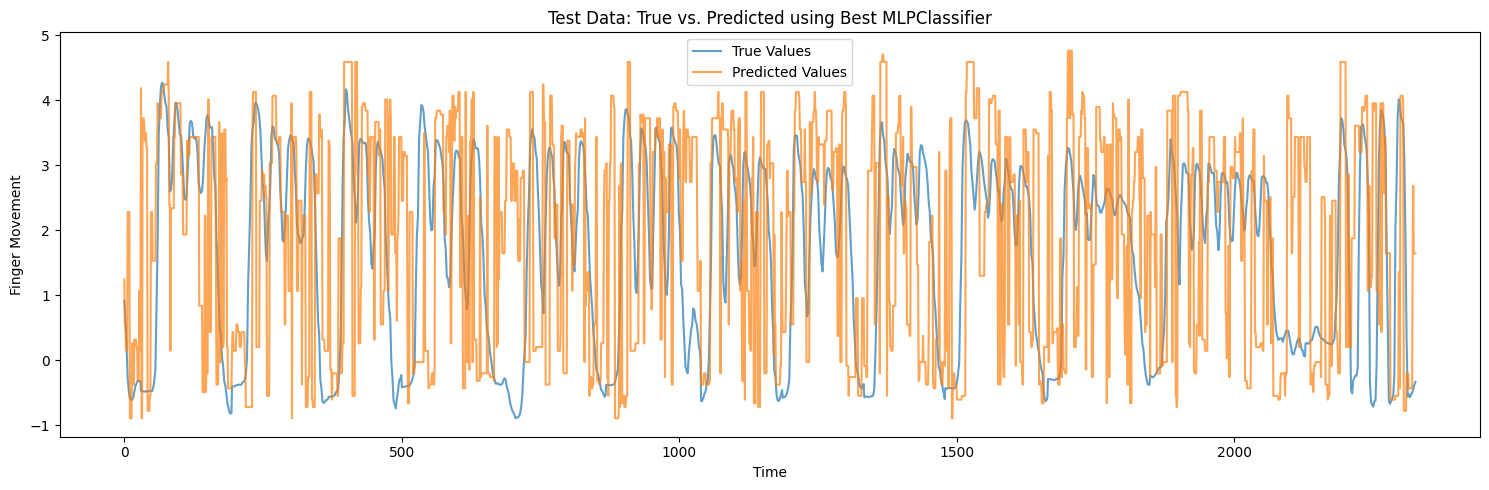

In [100]:
# Plotting the predictions from the best MLPClassifier alongside the true y values over time
plt.figure(figsize=(15, 5))

# Test data predictions
plt.plot(y_test, label="True Values", alpha=0.7)
plt.plot(Y_test_best_mlp_classifier_values, label="Predicted Values", alpha=0.7)
plt.title('Test Data: True vs. Predicted using Best MLPClassifier')
plt.xlabel('Time')
plt.ylabel('Finger Movement')
plt.legend()

plt.tight_layout()
plt.show()

The performance of the MLP Classifier model indicates a clear issue of overfitting to the training dataset, given the very low Mean Squared Error (MSE) on the training set and an R-squared ($R^2$) value of approximately 1. These underwhelming results stem from the fact that the MLP Classifier is inherently designed for classification tasks, not regression. This has prompted our decision to explore using an MLP Regressor instead to address the specific regression requirements of the problem

### MLP Regressor

In [101]:
NN=MLPRegressor()
NN.fit(x_train,y_train)

y_train_hat=NN.predict(x_train)
y_test_hat=NN.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.009500930363280606
MSE on test: 2.242469288267937
R² on train: 0.9969748013240406
R² on test: -0.05158060281247878


**Observation**

We see that the prediction on test dataset with MLPRegressor model is quite acceptable. The predicted curve simulates the test curve. However it has a default in not reaching low values. And predictions in the end are not good as well.

In [102]:
R=0
MSE=3
ngrid=100
alpha_opt=0
alpha=np.linspace(100,300,num=ngrid) 
for e in alpha:
    model=MLPRegressor(max_iter=200,alpha=e)                                
    model.fit(x_train,y_train)
    y_hat=model.predict(x_test)
    mse=mean_squared_error(y_test,y_hat)
    r_2=metrics.r2_score(y_test,y_hat)
    if (abs(r_2)>R) and (mse<MSE):
        R=r_2
        MSE=mse
        alpha_opt=e

In [103]:
NN_opt=MLPRegressor(max_iter=200,alpha=alpha_opt)
NN_opt.fit(x_train,y_train)

y_train_hat=NN_opt.predict(x_train)
y_test_hat=NN_opt.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 1.0923654004134917
MSE on test: 1.6075377374525281
R² on train: 0.65217907755997
R² on test: 0.24616336471665556


By fine-tuning the parameters of the MLP regressor, we achieved improved results on the test dataset. The Mean Squared Error (MSE) decreased from 2.32 to 1.619, and the R-squared ($R^2$) value increased from 0 to 0.24. It's worth noting that the MSE on the training dataset increased significantly, and the R-squared value decreased. This suggests that we successfully addressed the issue of overfitting to attain better performance on the test dataset.

From these observations, it becomes evident that the MLP model's performance is highly reliant on the specific parameters chosen for the model.

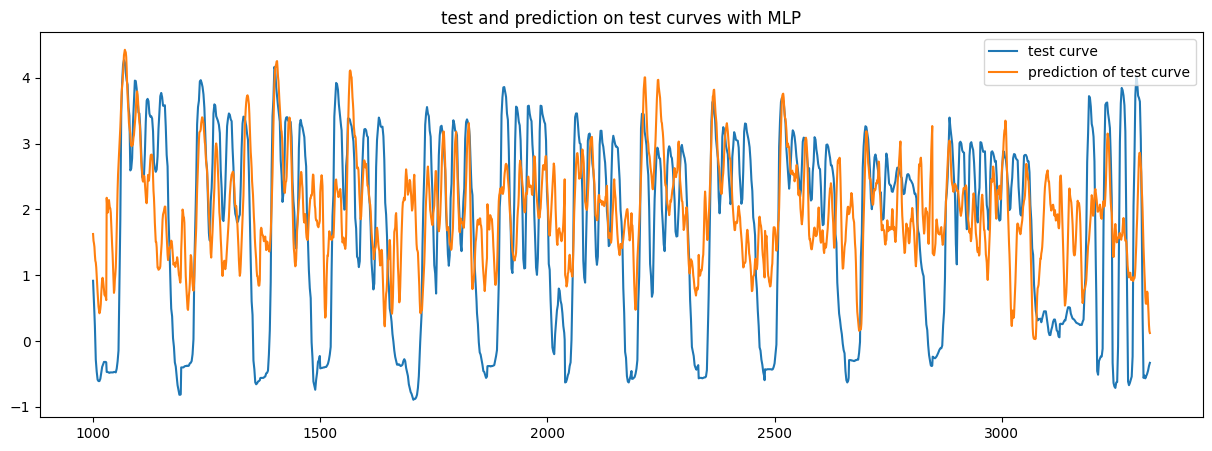

In [104]:
plt.figure(figsize=(15,5))
plt.plot(range(n,n+m),y_test,label="test curve")
plt.plot(range(n,n+m),y_test_hat,label="prediction of test curve")
plt.title("test and prediction on test curves with MLP")
plt.legend()
plt.show()

We see that the prediction on test dataset with MLPRegressor model is quite acceptable. The predicted curve simulates the test curve. However it has a default in not reaching low values. And predictions in the end are not good as well.

#  Final comparison of the performances

In [105]:
models=[LS,Ridge_opt,Lasso_opt,rf_opt,svr_opt,NN_opt]
data={"model":["LS","Ridge","Lasso","Random forest","SVR","MLPRegressor"],
      "MSE on test": [mean_squared_error(y_test,model.predict(x_test)) for model in models],
      "R²":[metrics.r2_score(y_test,model.predict(x_test)) for model in models]}
df = pd.DataFrame(data,columns=['model','MSE on test','R²'])
df

,model,MSE on test,R²
0,LS,3.045537,-0.428170
1,Ridge,1.623906,0.238488
2,Lasso,1.365954,0.359451
3,Random forest,1.574277,0.261761
4,SVR,1.512864,0.290559
5,MLPRegressor,1.607538,0.246163


We order the models by their performances on the test data starting from the best one:


1-Lasso


2-SVR

3-Random forest


4-MLPRegressor


5-Ridge


6-LS

The linear models, including LS, Lasso, and Ridge, are considered the most interpretable models. In contrast, the bagging models, such as Random Forest and Gradient Boosting, offer less interpretability. Additionally, nonlinear models like MLP are generally less interpretable compared to their linear counterparts.

In a medical and practical context, the most suitable model is linear regression with Lasso regularization. This choice is particularly advantageous in scenarios with high dimensionality because Lasso effectively retains only the most relevant and correlated variables. In this context, the variables correspond to the electrodes used in measurements. Opting for a more concise selection of electrodes is preferable to an excessive number placed on a subject's head. Our results demonstrate that Lasso regularization yields the most favorable outcomes, solidifying its position as the top-performing model for this particular task.

In this application, the need for non-linearity is minimal, as we have achieved excellent results using a linear regressor with Lasso regularization. Opting for non-linear models is not always advisable when we are already obtaining satisfactory outcomes with linear models.

Evaluating the model's performance on the test data is not a recommended practice. Ideally, the test data should not be utilized for model selection. Instead, it's advisable to either set aside a portion of the training dataset as validation data or employ cross-validation techniques on the training dataset to make informed decisions about model selection.


## Conclusion


In this practical assignment, we delved into the fascinating world of ECoG signals and their connection to finger movements. Through visualizations, we uncovered intriguing patterns that hint at potential links between specific variables and how our fingers move.

We didn't stop there; we dived into the realm of predictive modeling, exploring a range of machine learning techniques, from tried-and-true Linear Regression to more complex Neural Networks. We scrutinized each model's performance, considering their strengths and limitations, all in the quest to find the best way to predict finger movements based on ECoG signals.

Looking ahead, there's room for improvement. We could fine-tune our models, explore the depths of deep learning, or even incorporate additional data sources to enhance our prediction accuracy. The journey doesn't end here; it's just the beginning.